In [213]:
import pandas as pd

train = pd.read_csv('/home/huy/12T/QA4RE/data/BIORED/train.csv', sep='\t')
dev = pd.read_csv('/home/huy/12T/QA4RE/data/BIORED/dev.csv', sep='\t')
test = pd.read_csv('/home/huy/12T/QA4RE/data/BIORED/test.csv', sep='\t')

all_data = pd.concat([train, dev, test], ignore_index=True)

def create_possible_label_dict(csv_data):
    csv_data['ent_type_pair'] = csv_data['ent1_type'] + ' -> ' + csv_data['ent2_type']
    type_pair_labels = csv_data.groupby('ent_type_pair')['label'].apply(
        lambda x: sorted(x.unique().tolist())
    ).reset_index()

    type_pair_labels.columns = ['entity_type_combination', 'possible_labels']
    result = type_pair_labels.set_index('entity_type_combination').to_dict()['possible_labels']
    return result

import json
with open('/home/huy/12T/QA4RE/data/BIORED/configs/possible_labels.json', 'w') as f:
    json.dump(create_possible_label_dict(all_data), f)

## Evaluation by Entity Type Combinations

Now let's evaluate model performance broken down by entity type combinations and relation types, similar to Table S3.

In [3]:
# Load model predictions (example with the input_ready_df you have)
# You'll need to replace this with actual model output that has predictions
import pandas as pd
import sys
sys.path.append('/home/huy/12T/QA4RE')
from sklearn.metrics import f1_score, classification_report
from utils.eval_utils import evaluate_re_by_entity_type_combinations, evaluate_re_by_relation_type
from projs.re_templates import BIORED_LABEL_VERBALIZER

# For BIORED entity type abbreviations
entity_type_abbrev = {
    'GeneOrGeneProduct': 'G',
    'DiseaseOrPhenotypicFeature': 'D',
    'ChemicalEntity': 'C',
    'SequenceVariant': 'V'
}

# Load model predictions from file
# Replace this path with your actual model output file
output_df = pd.read_csv('/home/huy/12T/QA4RE/outputs/BIORED/multi_choice_qa4re/google-gemma-2-2b-it/zero_shot/0/test.gpt3.output.csv', sep='\t')
# output_df = pd.read_csv('/home/huy/12T/QA4RE/outputs/BIORED/multi_choice_qa4re/meta-llama-Llama-3.2-1B/zero_shot/0/test.gpt3.output.csv', sep='\t')
# output_df = pd.read_csv('/home/huy/12T/QA4RE/outputs/BIORED/vanilla_re/google-gemma-2-2b-it/zero_shot/0/test.gpt3.output.csv', sep='\t')
# output_df = pd.read_csv('/home/huy/12T/QA4RE/outputs/BIORED/vanilla_re/meta-llama-Llama-3.2-1B/zero_shot/0/test.gpt3.output.csv', sep='\t')
# output_df = pd.read_csv('/home/huy/12T/QA4RE/outputs/BIORED/vanilla_re/meta-llama-Llama-3.2-1B-Instruct/zero_shot/0/test.gpt3.output.csv', sep='\t')


print(f"Loaded {len(output_df)} predictions")
print(f"Columns: {output_df.columns.tolist()}")

/home/huy/miniconda3/envs/QA4RE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 1163 predictions
Columns: ['Unnamed: 0.1', 'Unnamed: 0', 'id', 'label', 'ent1_type', 'ent2_type', 'ent1', 'ent2', 'sents', 'masked_sents', 'verbalized_label', 'type_cons', 'prompts', 'empty_prompts', 'correct_choices', 'index2rels', 'all_choices', 'data_prompts', 'final_input_prompts', 'verbalized_labels', 'logit_biases', 'first_token_of_each_verb_label', 'cost', 'model_generations', 'predictions', 'time', 'binary_preds']


In [136]:
output_df = pd.read_csv('/home/huy/12T/QA4RE/outputs/BIORED/vanilla_re/google-gemma-2-2b-it/zero_shot/0/test.gpt3.output.csv', sep='\t')
print(output_df.data_prompts.iloc[0])

Sentence: A novel SCN5A mutation manifests as a malignant form of long QT syndrome with perinatal onset of tachycardia/bradycardia. OBJECTIVE: Congenital long QT syndrome (LQTS) with in utero onset of the rhythm disturbances is associated with a poor prognosis. In this study we investigated a newborn patient with fetal bradycardia, 2:1 atrioventricular block and ventricular tachycardia soon after birth. METHODS: Mutational analysis and DNA sequencing were conducted in a newborn. The 2:1 atrioventricular block improved to 1:1 conduction only after intravenous lidocaine infusion or a high dose of mexiletine, which also controlled the ventricular tachycardia. RESULTS: A novel, spontaneous LQTS-3 mutation was identified in the transmembrane segment 6 of domain IV of the Na(v)1.5 cardiac sodium channel, with a G-->A substitution at codon 1763, which changed a valine (GTG) to a methionine (ATG). The proband was heterozygous but the mutation was absent in the parents and the sister. Expressio

In [81]:
def calculate_f1(output_df):
    micro_f1 = f1_score(
        output_df['verbalized_label'],
        output_df['predictions'],
        average='weighted'
    )

    macro_f1 = f1_score(
        output_df['verbalized_label'],
        output_df['predictions'],
        average='macro'
    )

    weighted_f1 = f1_score(
        output_df['verbalized_label'],
        output_df['predictions'],
        average='weighted'
    )

    long_tail_df = output_df[output_df['verbalized_label']!='Association']
    long_tail_f1 = f1_score(
        long_tail_df['label'],
        long_tail_df['predictions'],
        average='macro'
    )

    return {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        # 'weighted_f1': weighted_f1,
        'long_tail_f1': long_tail_f1
    }

In [97]:
total_results = {}
for mode in ['multi_choice_qa4re', 'vanilla_re']:
    total_results[mode] = {}
    for model in ['google-gemma-2-2b','google-gemma-2-2b-it', 'meta-llama-Llama-3.2-1B', 'meta-llama-Llama-3.2-1B-Instruct']:
        output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/{mode}/{model}/zero_shot/seed_5/test.gpt3.output.csv', sep='\t')
        total_results[mode][model]= calculate_f1(output_df)
total_results

{'multi_choice_qa4re': {'google-gemma-2-2b': {'micro_f1': 0.3957451645013696,
   'macro_f1': 0.093767383282715,
   'long_tail_f1': 0.0059195893926432845},
  'google-gemma-2-2b-it': {'micro_f1': 0.42037366726031095,
   'macro_f1': 0.5041994119022628,
   'long_tail_f1': 0.5131109330706105},
  'meta-llama-Llama-3.2-1B': {'micro_f1': 0.4006327992303329,
   'macro_f1': 0.1396896030916849,
   'long_tail_f1': 0.1100728533582671},
  'meta-llama-Llama-3.2-1B-Instruct': {'micro_f1': 0.20890221100536618,
   'macro_f1': 0.12779922182309522,
   'long_tail_f1': 0.1664748518977802}},
 'vanilla_re': {'google-gemma-2-2b': {'micro_f1': 0.38434059674693116,
   'macro_f1': 0.0963420693381186,
   'long_tail_f1': 0.0},
  'google-gemma-2-2b-it': {'micro_f1': 0.2230173965543322,
   'macro_f1': 0.04853134637292921,
   'long_tail_f1': 0.0},
  'meta-llama-Llama-3.2-1B': {'micro_f1': 0.3692104651931883,
   'macro_f1': 0.08452593917710197,
   'long_tail_f1': 0.0},
  'meta-llama-Llama-3.2-1B-Instruct': {'micro_f1':

In [83]:
total_results = {}

for mode in ['multi_choice_qa4re_shuffle']:
    total_results[mode] = {}
    for model in ['google-gemma-2-2b-it', 'meta-llama-Llama-3.2-1B']:
        total_results[mode][model] = {}
        all_dfs = []
        
        for seed in [5, 1, 2, 9, 4]:
            output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/{mode}/{model}/zero_shot/seed_{seed}/test.gpt3.output.csv', sep='\t')
            all_dfs.append(output_df)
        
        # Merge all predictions by voting (majority vote across seeds)
        # Get predictions from each seed
        import numpy as np
        from collections import Counter
        
        # Collect predictions for each instance across all seeds
        voted_predictions = []
        for i in range(len(all_dfs[0])):
            # Get predictions for this instance from all seeds
            instance_predictions = [df.iloc[i]['predictions'] for df in all_dfs]
            # Find most common prediction (mode)
            vote_counts = Counter(instance_predictions)
            most_common_pred = vote_counts.most_common(1)[0][0]
            voted_predictions.append(most_common_pred)
        
        # Create merged dataframe with voted predictions
        merged_df = all_dfs[0].copy()
        merged_df['predictions'] = voted_predictions
        
        # Calculate results on merged predictions
        total_results[mode][model]['voted'] = calculate_f1(merged_df)
        
        # Also calculate average F1 across individual seeds for comparison
        seed_results = [calculate_f1(df) for df in all_dfs]
        avg_results = {}
        for metric in ['micro_f1', 'macro_f1', 'long_tail_f1']:
            avg_results[metric] = np.mean([r[metric] for r in seed_results])
            avg_results[metric + '_std'] = np.std([r[metric] for r in seed_results])
        total_results[mode][model]['average'] = avg_results

# Display results
for model in ['google-gemma-2-2b-it', 'meta-llama-Llama-3.2-1B']:
    print(f"\n{'='*60}")
    print(f"Model: {model}")
    print('='*60)
    
    print("\nVoted predictions (majority vote across 5 seeds):")
    voted_results = total_results['multi_choice_qa4re_shuffle'][model]['voted']
    for metric, value in voted_results.items():
        print(f"  {metric}: {value*100:.2f}%")
    
    print("\nAverage across individual seeds (mean ± std):")
    avg_results = total_results['multi_choice_qa4re_shuffle'][model]['average']
    for metric in ['micro_f1', 'macro_f1', 'long_tail_f1']:
        mean = avg_results[metric] * 100
        std = avg_results[metric + '_std'] * 100
        print(f"  {metric}: {mean:.2f}% ± {std:.2f}%")


Model: google-gemma-2-2b-it

Voted predictions (majority vote across 5 seeds):
  micro_f1: 48.67%
  macro_f1: 41.20%
  long_tail_f1: 36.78%

Average across individual seeds (mean ± std):
  micro_f1: 46.42% ± 0.86%
  macro_f1: 35.91% ± 3.00%
  long_tail_f1: 33.89% ± 3.28%

Model: meta-llama-Llama-3.2-1B

Voted predictions (majority vote across 5 seeds):
  micro_f1: 37.02%
  macro_f1: 13.45%
  long_tail_f1: 11.62%

Average across individual seeds (mean ± std):
  micro_f1: 35.30% ± 0.97%
  macro_f1: 14.24% ± 0.83%
  long_tail_f1: 12.91% ± 1.27%


In [84]:
output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/multi_choice_qa4re_shuffle/google-gemma-2-2b-it/zero_shot/seed_5/test.gpt3.output.csv', sep='\t')
calculate_f1(output_df)

{'micro_f1': 0.4616662725596604,
 'macro_f1': 0.3556109274574124,
 'long_tail_f1': 0.3188643279761299}

In [138]:
output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/multi_choice_qa4re_with_definitions/google-gemma-2-2b-it/zero_shot/seed_5/test.gpt3.output.csv', sep='\t')
calculate_f1(output_df)

{'micro_f1': 0.450035885081446,
 'macro_f1': 0.2404183761544923,
 'long_tail_f1': 0.21512961865318292}

In [139]:
output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/multi_choice_qa4re/google-gemma-2-2b-it/zero_shot/seed_5/test.gpt3.output.csv', sep='\t')
calculate_f1(output_df)

{'micro_f1': 0.42037366726031095,
 'macro_f1': 0.5041994119022628,
 'long_tail_f1': 0.5131109330706105}

In [143]:
output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/multi_choice_qa4re/meta-llama-Llama-3.2-1B/zero_shot/seed_5/test.gpt3.output.csv', sep='\t')
calculate_f1(output_df)

{'micro_f1': 0.4006327992303329,
 'macro_f1': 0.1396896030916849,
 'long_tail_f1': 0.1100728533582671}

In [88]:
output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/multi_choice_qa4re/meta-llama-Llama-3.2-1B/zero_shot/seed_5/test.gpt3.output.csv', sep='\t')
calculate_f1(output_df)

{'micro_f1': 0.4006327992303329,
 'macro_f1': 0.1396896030916849,
 'long_tail_f1': 0.1100728533582671}

In [95]:
output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/multi_choice_qa4re_shuffle/meta-llama-Llama-3.2-1B/zero_shot/seed_4/test.gpt3.output.csv', sep='\t')
calculate_f1(output_df)

{'micro_f1': 0.36136487980419546,
 'macro_f1': 0.13747504494816873,
 'long_tail_f1': 0.12019534690159234}

In [99]:
# Merge multi_choice_qa4re and vanilla_re results, grouped by model
import pandas as pd

# Create a combined dataframe
merged_results = []

for model in ['google-gemma-2-2b', 'google-gemma-2-2b-it', 'meta-llama-Llama-3.2-1B', 'meta-llama-Llama-3.2-1B-Instruct']:
    # Add vanilla_re results first
    vanilla_row = total_results['vanilla_re'][model].copy()
    vanilla_row['method'] = 'vanilla_re'
    vanilla_row['model'] = model
    # Convert to percentage with 1 decimal
    for metric in ['micro_f1', 'macro_f1',  'long_tail_f1']:
        vanilla_row[metric] = round(vanilla_row[metric] * 100, 1)
    merged_results.append(vanilla_row)
    
    # Then add multi_choice_qa4re results
    qa4re_row = total_results['multi_choice_qa4re'][model].copy()
    qa4re_row['method'] = 'multi_choice_qa4re'
    qa4re_row['model'] = model
    # Convert to percentage with 1 decimal
    for metric in ['micro_f1', 'macro_f1',  'long_tail_f1']:
        qa4re_row[metric] = round(qa4re_row[metric] * 100, 1)
    merged_results.append(qa4re_row)
    
    # Add delta row (qa4re - vanilla)
    delta_row = {}
    for metric in ['micro_f1', 'macro_f1', 'long_tail_f1']:
        # Calculate delta in percentage points with 1 decimal
        delta_row[metric] = round((total_results['multi_choice_qa4re'][model][metric] - total_results['vanilla_re'][model][metric]) * 100, 1)
    delta_row['method'] = 'delta (qa4re - vanilla)'
    delta_row['model'] = model
    merged_results.append(delta_row)

# Create DataFrame
merged_df = pd.DataFrame(merged_results)

# Reorder columns to have model and method first
cols = ['model', 'method', 'micro_f1', 'macro_f1',  'long_tail_f1']
merged_df = merged_df[cols]

# Optional: Set multi-index for better grouping visualization
merged_df_indexed = merged_df.set_index(['model', 'method'])

# Format the display to highlight positive/negative deltas only in delta rows
def highlight_delta(row):
    # Only apply styling to delta rows
    if 'delta' in row.name[1]:  # Check if method contains 'delta'
        colors = []
        for val in row:
            if isinstance(val, (int, float)):
                if val > 0:
                    colors.append('color: green')
                elif val < 0:
                    colors.append('color: red')
                else:
                    colors.append('color: black')
            else:
                colors.append('')
        return colors
    else:
        return [''] * len(row)

# Apply formatting and display with 1 decimal place
merged_df_indexed.style.apply(highlight_delta, axis=1).format("{:.1f}", subset=['micro_f1', 'macro_f1', 'long_tail_f1'])

In [8]:
total_results = {}
for model in ['google-gemma-2-2b-it', 'meta-llama-Llama-3.2-1B']:
    for mode in ['vanilla_re', 'multi_choice_qa4re']:    
        output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/{mode}/{model}/zero_shot/seed_5/test.gpt3.output.csv', sep='\t')

        # Evaluate by entity type combinations - produces Table S3 style output
        results_table = evaluate_re_by_entity_type_combinations(
            output_df, 
            label_verbalizer=BIORED_LABEL_VERBALIZER,
            prediction_name='predictions',
            entity_type_abbrev=entity_type_abbrev,
            return_dataframe=True
        )

        considered_columns = ['G,D', 'G,G', 'G,C', 'D,V', 'C,D', 'C,V', 'C,C']
        considered_rows = ['association', 'positive correlation', 'negative correlation',
                        'cotreatment', 'drug interaction', 'binding', 'comparison',
                        'conversion', 'Overall']

        # Display the table
        results_table = results_table.loc[considered_rows, considered_columns]
        print(mode, model, results_table.loc['Overall'].mean())
        display(results_table.style.format("{:.1f}", subset=considered_columns))

vanilla_re google-gemma-2-2b-it 17.041884232213825


,"G,D","G,G","G,C","D,V","C,D","C,V","C,C"
association,61.1,24.4,43.2,26.5,17.1,nan,6.5
positive correlation,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative correlation,0.0,0.0,0.0,nan,0.0,0.0,0.0
cotreatment,nan,nan,0.0,nan,nan,nan,0.0
drug interaction,nan,nan,nan,nan,nan,nan,0.0
binding,nan,0.0,0.0,nan,nan,nan,nan
comparison,nan,nan,nan,nan,nan,nan,37.5
conversion,nan,nan,nan,nan,nan,nan,50.0
Overall,52.4,15.0,20.8,19.0,3.4,0.0,8.8


multi_choice_qa4re google-gemma-2-2b-it 41.22763616689251


,"G,D","G,G","G,C","D,V","C,D","C,V","C,C"
association,64.0,0.0,0.0,84.6,18.0,nan,0.0
positive correlation,14.5,48.1,60.8,7.7,34.4,40.0,38.9
negative correlation,19.0,51.5,15.4,nan,37.9,0.0,38.6
cotreatment,nan,nan,66.7,nan,nan,nan,62.1
drug interaction,nan,nan,nan,nan,nan,nan,15.4
binding,nan,0.0,0.0,nan,nan,nan,nan
comparison,nan,nan,nan,nan,nan,nan,50.0
conversion,nan,nan,nan,nan,nan,nan,100.0
Overall,48.5,34.2,42.9,73.6,29.4,25.0,35.1


vanilla_re meta-llama-Llama-3.2-1B 39.01816058488537


,"G,D","G,G","G,C","D,V","C,D","C,V","C,C"
association,89.0,69.0,62.1,82.1,24.8,nan,35.2
positive correlation,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative correlation,0.0,0.0,0.0,nan,0.0,0.0,0.0
cotreatment,nan,nan,0.0,nan,nan,nan,0.0
drug interaction,nan,nan,nan,nan,nan,nan,0.0
binding,nan,0.0,0.0,nan,nan,nan,nan
comparison,nan,nan,nan,nan,nan,nan,0.0
conversion,nan,nan,nan,nan,nan,nan,0.0
Overall,79.8,49.6,42.9,68.1,12.6,0.0,20.2


multi_choice_qa4re meta-llama-Llama-3.2-1B 29.6485465634868


,"G,D","G,G","G,C","D,V","C,D","C,V","C,C"
association,64.3,12.6,0.0,79.1,20.0,nan,0.0
positive correlation,4.3,39.3,0.0,41.7,26.7,0.0,0.0
negative correlation,16.3,5.3,27.1,nan,24.5,0.0,48.4
cotreatment,nan,nan,0.0,nan,nan,nan,0.0
drug interaction,nan,nan,nan,nan,nan,nan,0.0
binding,nan,0.0,66.7,nan,nan,nan,nan
comparison,nan,nan,nan,nan,nan,nan,0.0
conversion,nan,nan,nan,nan,nan,nan,0.0
Overall,48.5,19.2,14.3,69.2,24.5,0.0,31.9


In [100]:
# Evaluate and merge results for both vanilla_re and multi_choice_qa4re
import pandas as pd
from sklearn.metrics import f1_score

all_results = {}
for model in ['google-gemma-2-2b-it', 'meta-llama-Llama-3.2-1B']:
    all_results[model] = {}
    
    for mode in ['vanilla_re', 'multi_choice_qa4re']:    
        output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/{mode}/{model}/zero_shot/seed_5/test.gpt3.output.csv', sep='\t')

        # Evaluate by entity type combinations - produces Table S3 style output
        results_table = evaluate_re_by_entity_type_combinations(
            output_df, 
            label_verbalizer=BIORED_LABEL_VERBALIZER,
            prediction_name='predictions',
            entity_type_abbrev=entity_type_abbrev,
            return_dataframe=True
        )

        considered_columns = ['G,D', 'G,G', 'G,C', 'D,V', 'C,D', 'C,V', 'C,C']
        considered_rows = ['association', 'positive correlation', 'negative correlation',
                        'cotreatment', 'drug interaction', 'binding', 'comparison',
                        'conversion', 'Overall']

        # Store results
        results_table = results_table.loc[considered_rows, considered_columns]
        all_results[model][mode] = results_table
        
        print(f"{mode} - {model}: Overall mean = {results_table.loc['Overall'].mean():.1f}")

# Now create merged tables for each model
for model in ['google-gemma-2-2b-it', 'meta-llama-Llama-3.2-1B']:
    print(f"\n{'='*80}")
    print(f"Model: {model}")
    print('='*80)
    
    # Get vanilla and qa4re results
    vanilla_table = all_results[model]['vanilla_re'].copy()
    qa4re_table = all_results[model]['multi_choice_qa4re'].copy()
    
    # Create combined table by interleaving rows for each relation
    combined_rows = []
    for relation in considered_rows:
        # Add vanilla row
        vanilla_row = vanilla_table.loc[relation].copy()
        combined_rows.append(('vanilla_re', relation, *vanilla_row))
        
        # Add qa4re row
        qa4re_row = qa4re_table.loc[relation].copy()
        combined_rows.append(('qa4re', relation, *qa4re_row))
        
        # Add delta row
        delta_row = qa4re_table.loc[relation] - vanilla_table.loc[relation]
        combined_rows.append(('delta', relation, *delta_row))
    
    # Create DataFrame with multi-index
    combined_table = pd.DataFrame(
        combined_rows,
        columns=['method', 'relation'] + considered_columns
    )
    combined_table = combined_table.set_index(['relation', 'method'])
    
    # Format and highlight delta rows
    def highlight_delta(row):
        # Only apply styling to delta rows
        if 'delta' in row.name[1]:
            colors = []
            for val in row:
                if isinstance(val, (int, float)):
                    if val > 0:
                        colors.append('color: green')
                    elif val < 0:
                        colors.append('color: red')
                    else:
                        colors.append('color: black')
                else:
                    colors.append('')
            return colors
        else:
            return [''] * len(row)
    
    display(combined_table.style.apply(highlight_delta, axis=1).format("{:.1f}", subset=considered_columns, na_rep="-"))

vanilla_re - google-gemma-2-2b-it: Overall mean = 17.0
multi_choice_qa4re - google-gemma-2-2b-it: Overall mean = 41.2
vanilla_re - meta-llama-Llama-3.2-1B: Overall mean = 39.0
multi_choice_qa4re - meta-llama-Llama-3.2-1B: Overall mean = 29.6

Model: google-gemma-2-2b-it
vanilla_re - meta-llama-Llama-3.2-1B: Overall mean = 39.0
multi_choice_qa4re - meta-llama-Llama-3.2-1B: Overall mean = 29.6

Model: google-gemma-2-2b-it



Model: meta-llama-Llama-3.2-1B


In [50]:
# Create a counts table showing number of samples for each combination
def get_sample_counts_by_entity_type_combinations(df, entity_type_abbrev=None):
    """
    Create a table showing the number of samples for each relation type and entity type combination.
    """
    df = df.copy()
    
    # Create entity type pair column
    df['ent_type_pair'] = df['ent1_type'] + ' -> ' + df['ent2_type']
    
    # Create abbreviated version if mapping provided
    if entity_type_abbrev:
        df['ent_type_pair_abbrev'] = df['ent1_type'].map(entity_type_abbrev) + ',' + df['ent2_type'].map(entity_type_abbrev)
        type_pair_col = 'ent_type_pair_abbrev'
    else:
        type_pair_col = 'ent_type_pair'
    
    # Get all unique relation types and entity type pairs
    all_relations = sorted(df['verbalized_label'].unique())
    all_relations = [BIORED_LABEL_VERBALIZER[c] for c in all_relations] 
    all_type_pairs = sorted(df[type_pair_col].unique())
    
    # Initialize results dictionary
    results = {rel: {} for rel in all_relations}
    results['Overall'] = {}
    
    # Count samples for each relation type and entity type pair
    for type_pair in all_type_pairs:
        subset = df[df[type_pair_col] == type_pair]
        
        # Overall count for this entity type pair
        results['Overall'][type_pair] = len(subset)
        
        # Count for each specific relation type
        for rel in all_relations:
            rel_subset = subset[subset['verbalized_label'].apply(BIORED_LABEL_VERBALIZER.get) == rel]
            count = len(rel_subset)
            results[rel][type_pair] = count if count > 0 else None
    
    # Create DataFrame
    results_df = pd.DataFrame(results).T
    results_df = results_df[sorted(results_df.columns)]  # Sort columns
    
    # Move 'Overall' row to the bottom
    if 'Overall' in results_df.index:
        overall_row = results_df.loc['Overall']
        results_df = results_df.drop('Overall')
        results_df = pd.concat([results_df, overall_row.to_frame().T])
    
    return results_df

# Generate the counts table
counts_table = get_sample_counts_by_entity_type_combinations(
    output_df,
    entity_type_abbrev=entity_type_abbrev
)

counts_table.loc[considered_rows, considered_columns]

,"G,D","G,G","G,C","D,V","C,D","C,V","C,C"
association,144.0,141.0,27.0,67.0,18.0,NaN,25.0
positive correlation,9.0,72.0,24.0,24.0,81.0,1.0,19.0
negative correlation,10.0,24.0,8.0,NaN,44.0,3.0,30.0
cotreatment,NaN,NaN,3.0,NaN,NaN,NaN,11.0
drug interaction,NaN,NaN,NaN,NaN,NaN,NaN,2.0
binding,NaN,3.0,1.0,NaN,NaN,NaN,NaN
comparison,NaN,NaN,NaN,NaN,NaN,NaN,6.0
conversion,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Overall,163.0,240.0,63.0,91.0,143.0,4.0,94.0


In [36]:
mode = 'multi_choice_qa4re_with_definitions'
model = 'google-gemma-2-2b-it'
output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/{mode}/{model}/zero_shot/seed_5/test.gpt3.output.csv', sep='\t')

relation_results = evaluate_re_by_relation_type(
    output_df,
    label_verbalizer=BIORED_LABEL_VERBALIZER,
    prediction_name='predictions',
    return_dataframe=True
)
print(mode, model)
display(relation_results)

multi_choice_qa4re_with_definitions google-gemma-2-2b-it


,Relation Type,Count,Precision,Recall,F1
0,association,635,58.593750,70.866142,64.148254
1,binding,9,8.333333,11.111111,9.523810
2,comparison,6,21.428571,50.000000,30.000000
3,conversion,1,0.000000,0.000000,0.000000
4,cotreatment,14,19.718310,100.000000,32.941176
5,drug interaction,2,10.000000,50.000000,16.666667
6,negative correlation,171,41.379310,7.017544,12.000000
7,positive correlation,325,30.501931,24.307692,27.054795


In [11]:
for model in ['google-gemma-2-2b-it', 'meta-llama-Llama-3.2-1B']:    
    for mode in ['vanilla_re', 'multi_choice_qa4re']:    
        output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/{mode}/{model}/zero_shot/seed_5/test.gpt3.output.csv', sep='\t')

        relation_results = evaluate_re_by_relation_type(
            output_df,
            label_verbalizer=BIORED_LABEL_VERBALIZER,
            prediction_name='predictions',
            return_dataframe=True
        )
        print(mode, model)
        display(relation_results)

vanilla_re google-gemma-2-2b-it


,Relation Type,Count,Precision,Recall,F1
0,association,635,72.580645,28.346457,40.770102
1,binding,9,0.000000,0.000000,0.000000
2,comparison,6,3.797468,50.000000,7.058824
3,conversion,1,2.857143,100.000000,5.555556
4,cotreatment,14,0.000000,0.000000,0.000000
5,drug interaction,2,0.000000,0.000000,0.000000
6,negative correlation,171,0.000000,0.000000,0.000000
7,positive correlation,325,0.000000,0.000000,0.000000


multi_choice_qa4re google-gemma-2-2b-it


,Relation Type,Count,Precision,Recall,F1
0,association,635,62.314540,33.070866,43.209877
1,binding,9,66.666667,44.444444,53.333333
2,comparison,6,50.000000,50.000000,50.000000
3,conversion,1,100.000000,100.000000,100.000000
4,cotreatment,14,52.380952,78.571429,62.857143
5,drug interaction,2,8.333333,100.000000,15.384615
6,negative correlation,171,43.609023,33.918129,38.157895
7,positive correlation,325,30.551181,59.692308,40.416667


vanilla_re meta-llama-Llama-3.2-1B


,Relation Type,Count,Precision,Recall,F1
0,association,635,54.414587,89.291339,67.620751
1,binding,9,0.000000,0.000000,0.000000
2,comparison,6,0.000000,0.000000,0.000000
3,conversion,1,0.000000,0.000000,0.000000
4,cotreatment,14,0.000000,0.000000,0.000000
5,drug interaction,2,0.000000,0.000000,0.000000
6,negative correlation,171,0.000000,0.000000,0.000000
7,positive correlation,325,0.000000,0.000000,0.000000


multi_choice_qa4re meta-llama-Llama-3.2-1B


,Relation Type,Count,Precision,Recall,F1
0,association,635,66.246851,41.417323,50.968992
1,binding,9,3.225806,11.111111,5.000000
2,comparison,6,0.000000,0.000000,0.000000
3,conversion,1,0.000000,0.000000,0.000000
4,cotreatment,14,0.000000,0.000000,0.000000
5,drug interaction,2,0.000000,0.000000,0.000000
6,negative correlation,171,17.906977,45.029240,25.623960
7,positive correlation,325,31.147541,29.230769,30.158730


In [137]:
# Evaluate and merge relation_results for both vanilla_re and multi_choice_qa4re
MODELS = ['google-gemma-2-2b-it', 'meta-llama-Llama-3.2-1B']
MODES = ['vanilla_re', 'multi_choice_qa4re']#, 'multi_choice_qa4re_with_definitions']
all_relation_results = {}
for model in MODELS:
    all_relation_results[model] = {}
    
    for mode in MODES:    
        output_df = pd.read_csv(f'/home/huy/12T/QA4RE/outputs/BIORED/{mode}/{model}/zero_shot/seed_5/test.gpt3.output.csv', sep='\t')

        relation_results = evaluate_re_by_relation_type(
            output_df,
            label_verbalizer=BIORED_LABEL_VERBALIZER,
            prediction_name='predictions',
            return_dataframe=True
        )
        
        # Store results
        all_relation_results[model][mode] = relation_results
        print(f"{mode} - {model}")

# Now create merged tables for each model
for model in MODELS:
    print(f"\n{'='*80}")
    print(f"Model: {model}")
    print('='*80)
    
    # Get vanilla and qa4re results
    vanilla_results = all_relation_results[model][MODES[0]].copy()
    qa4re_results = all_relation_results[model][MODES[1]].copy()
    
    # Get list of relations
    relations = vanilla_results['Relation Type'].tolist()
    
    # Create combined rows
    combined_rows = []
    for relation in relations:
        # Get vanilla row
        vanilla_row = vanilla_results[vanilla_results['Relation Type'] == relation].iloc[0]
        combined_rows.append((MODES[0], relation, vanilla_row['Count'], 
                            vanilla_row['Precision'], vanilla_row['Recall'], vanilla_row['F1']))
        
        # Get qa4re row
        qa4re_row = qa4re_results[qa4re_results['Relation Type'] == relation].iloc[0]
        combined_rows.append((MODES[1], relation, qa4re_row['Count'],
                            qa4re_row['Precision'], qa4re_row['Recall'], qa4re_row['F1']))
        
        # Calculate delta (no delta for support/count)
        delta_precision = qa4re_row['Precision'] - vanilla_row['Precision']
        delta_recall = qa4re_row['Recall'] - vanilla_row['Recall']
        delta_f1 = qa4re_row['F1'] - vanilla_row['F1']
        combined_rows.append(('delta', relation, '',
                            delta_precision, delta_recall, delta_f1))
    
    # Create DataFrame with multi-index
    combined_table = pd.DataFrame(
        combined_rows,
        columns=['method', 'relation', 'support', 'precision', 'recall', 'f1_score']
    )
    combined_table = combined_table.set_index(['relation', 'method'])
    
    # Format and highlight delta rows
    def highlight_delta(row):
        # Only apply styling to delta rows
        if 'delta' in row.name[1]:
            colors = []
            for i, val in enumerate(row):
                # Skip support column (first column) for delta rows
                if i == 0:
                    colors.append('')
                elif isinstance(val, (int, float)):
                    if val > 0:
                        colors.append('color: green')
                    elif val < 0:
                        colors.append('color: red')
                    else:
                        colors.append('color: black')
                else:
                    colors.append('')
            return colors
        else:
            return [''] * len(row)
    
    display(combined_table.style.apply(highlight_delta, axis=1).format("{:.1f}", subset=['precision', 'recall', 'f1_score']))

vanilla_re - google-gemma-2-2b-it
multi_choice_qa4re - google-gemma-2-2b-it
vanilla_re - meta-llama-Llama-3.2-1B
multi_choice_qa4re - meta-llama-Llama-3.2-1B

Model: google-gemma-2-2b-it
vanilla_re - meta-llama-Llama-3.2-1B
multi_choice_qa4re - meta-llama-Llama-3.2-1B

Model: google-gemma-2-2b-it



Model: meta-llama-Llama-3.2-1B


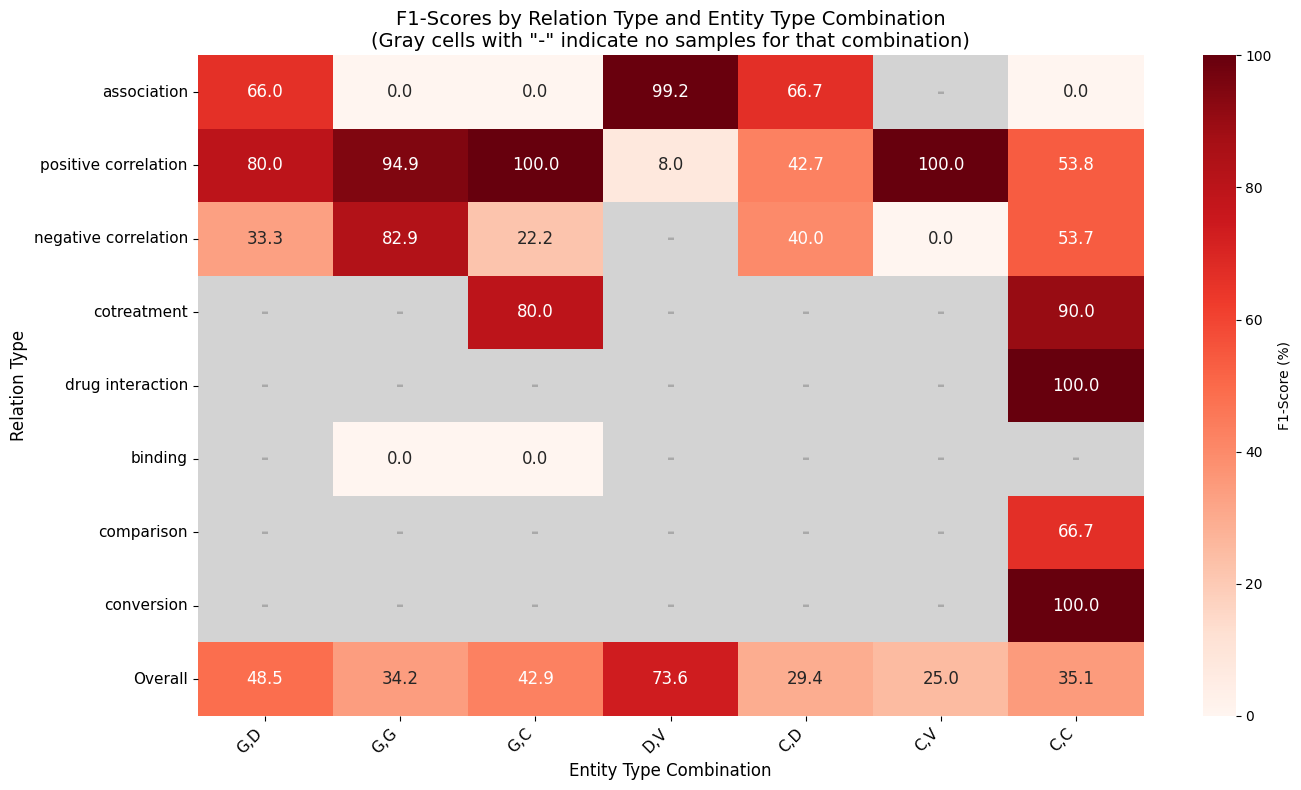

In [35]:
# Visualization: Heatmap of F1-scores by entity type and relation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a masked array where NaN values are masked
# This way they'll be shown differently from 0.0 scores
fig, ax = plt.subplots(figsize=(14, 8))

# Create a custom colormap that shows NaN values as gray
from matplotlib.colors import ListedColormap
cmap = sns.color_palette("Reds", as_cmap=True)
cmap.set_bad(color='lightgray')  # NaN values will be light gray

# Create the heatmap with masked NaN values
sns.heatmap(results_table, annot=True, fmt='.1f', cmap=cmap,
            vmin=0, vmax=100, cbar_kws={'label': 'F1-Score (%)'}, 
            mask=results_table.isna(), ax=ax, annot_kws={'size': 12})

# Add another heatmap layer for the NaN cells with different style
# This will show "-" instead of numbers for NaN cells
for i in range(len(results_table.index)):
    for j in range(len(results_table.columns)):
        if pd.isna(results_table.iloc[i, j]):
            ax.text(j + 0.5, i + 0.5, '-', 
                   ha='center', va='center', color='darkgray', fontsize=14, weight='bold')

plt.title('F1-Scores by Relation Type and Entity Type Combination\n(Gray cells with "-" indicate no samples for that combination)', fontsize=14)
plt.xlabel('Entity Type Combination', fontsize=12)
plt.ylabel('Relation Type', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

In [ ]:
# Export results to CSV for further analysis or paper tables
results_table.to_csv('/home/huy/12T/QA4RE/outputs/BIORED/entity_type_combination_results.csv')
relation_results.to_csv('/home/huy/12T/QA4RE/outputs/BIORED/relation_type_results.csv', index=False)

print("Results saved!")
print(f"Entity type combination results: /home/huy/12T/QA4RE/outputs/BIORED/entity_type_combination_results.csv")
print(f"Relation type results: /home/huy/12T/QA4RE/outputs/BIORED/relation_type_results.csv")

In [22]:
input_df = pd.read_pickle('/home/huy/12T/QA4RE/projs/QA4RE/input_ready_df.pkl')
print(input_df.sample().iloc[0].final_input_prompts)

Determine which option can be inferred from the given Sentence.

Sentence: Critical role of neuronal pentraxin 1 in mitochondria-mediated hypoxic-ischemic neuronal injury. Developing brain is highly susceptible to hypoxic-ischemic (HI) injury leading to severe neurological disabilities in surviving infants and children. Previously, we have reported induction of neuronal pentraxin 1 (NP1), a novel neuronal protein of long-pentraxin family, following HI neuronal injury. Here, we investigated how this specific signal is propagated to cause the HI neuronal death. We used wild-type (WT) and NP1 knockout (NP1-KO) mouse hippocampal cultures, modeled in vitro following exposure to oxygen glucose deprivation (OGD), and in vivo neonatal (P9-10) mouse model of HI brain injury. Our results show induction of NP1 in primary hippocampal neurons following OGD exposure (4-8 h) and in the ipsilateral hippocampal CA1 and CA3 regions at 24-48 h post-HI compared to the contralateral side. We also found inc